The de_train.parquet file comprises the main competition data. It contains values for a number of cell_type / sm_name pairs. Your goal is to predict corresponding values for the cell_type / sm_name pairs given in id_map.csv.

In [64]:
# load in all data from open-problems-single-cell-perturbations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scanpy as sc
import anndata as ad
import scipy as sp
import pyarrow.parquet as pq
import fastparquet
import tqdm
# import gc
# import glob
import random
# from scipy import stats
# from pathlib import Path
# from itertools import groupby

# define plot parameters
sns.set_palette("viridis")
sns.set_style("whitegrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [8, 6]

In [65]:
# read in csv
path = "/home/katerchen/Code/data/open-problems-single-cell-perturbations/"
adata_obs = pd.read_csv(path + "adata_obs_meta.csv")
# id_map = pd.read_csv(path + "id_map.csv")
multiome_obs_meta = pd.read_csv(path + "multiome_obs_meta.csv")
multiome_var_meta = pd.read_csv(path + "multiome_var_meta.csv")

In [66]:
adata_obs

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240085,ffff28f274e983df,library_27,plate_0,G12,G,12,PBMC,donor_0,NK cells,LSM-3349,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,1.0,24,False
240086,ffff32893af5befb,library_31,plate_4,E7,E,7,PBMC,donor_2,T cells CD4+,LSM-2287,Midostaurin,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,1.0,24,False
240087,ffff6c3e0a7b05ad,library_38,plate_1,C5,C,5,PBMC,donor_2,NK cells,LSM-45786,BAY 87-2243,Cc1cc(-c2nc(-c3ccc(OC(F)(F)F)cc3)no2)nn1Cc1ccn...,1.0,24,False
240088,ffff8e571c7e8cb0,library_28,plate_5,B1,B,1,PBMC,donor_1,B cells,LSM-43181,Belinostat,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,0.1,24,True


In [67]:
multiome_obs_meta

,obs_id,cell_type,donor_id
0,000225c1151ab841,B cells,donor_0
1,0003c40a54367871,T cells CD4+,donor_2
2,0004bf574b822c3c,T cells CD4+,donor_2
3,000d59b5478f28e2,B cells,donor_0
4,0011b7473923d7b5,NK cells,donor_2
...,...,...,...
25546,fff2ca1f64c10339,T cells CD4+,donor_0
25547,fff87e64f509b570,T cells CD4+,donor_0
25548,fff9778b31bc2539,Myeloid cells,donor_2
25549,fffa92f71d2440de,NK cells,donor_1


In [68]:
multiome_var_meta

,location,gene_id,feature_type,genome,interval
0,A1BG,ENSG00000121410,Gene Expression,GRCh38,chr19:58353491-58353492
1,A1BG-AS1,ENSG00000268895,Gene Expression,GRCh38,chr19:58347750-58351970
2,A2M,ENSG00000175899,Gene Expression,GRCh38,chr12:9116156-9116157
3,A2M-AS1,ENSG00000245105,Gene Expression,GRCh38,chr12:9065162-9065177
4,A2ML1,ENSG00000166535,Gene Expression,GRCh38,chr12:8822620-8845004
...,...,...,...,...,...
158200,chrY:7765105-7765991,chrY:7765105-7765991,Peaks,GRCh38,chrY:7765105-7765991
158201,chrY:7814158-7815060,chrY:7814158-7815060,Peaks,GRCh38,chrY:7814158-7815060
158202,chrY:7818681-7819599,chrY:7818681-7819599,Peaks,GRCh38,chrY:7818681-7819599
158203,chrY:8535565-8536421,chrY:8535565-8536421,Peaks,GRCh38,chrY:8535565-8536421


In [69]:
# adata_train =pd.read_parquet(path + "adata_train.parquet")

In [70]:
de_train = pd.read_parquet(path + "de_train.parquet")

de_train_meta = de_train.iloc[:, :5]
de_train_meta.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False


In [71]:
MV = de_train.isnull().sum()
print('Missing Value de_train:', MV[MV > 0])
print('Duplicates in cell_type:', de_train.cell_type.duplicated().sum())
print('Duplicates in sm_name:', de_train.sm_name.duplicated().sum())

Missing Value de_train: Series([], dtype: int64)
Duplicates in cell_type: 608
Duplicates in sm_name: 468


In [72]:
cell_type_list = list(de_train['cell_type'].unique())
print(cell_type_list)
len(cell_type_list)

['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']


6

count
cell_type          control       
B cells            False       15
                   True         2
Myeloid cells      False       15
                   True         2
NK cells           False      144
                   True         2
T cells CD4+       False      144
                   True         2
T cells CD8+       False      140
                   True         2
T regulatory cells False      144
                   True         2

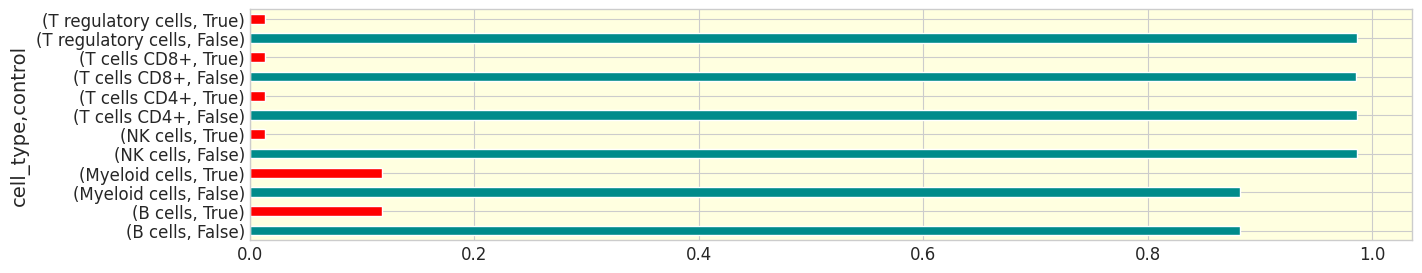

In [73]:
plt.gca().set_facecolor('lightyellow')
de_train.groupby('cell_type')['control'].value_counts(normalize=True).plot(kind='barh', figsize=(15,3), color=['darkcyan','red'])

pd.DataFrame(de_train.groupby('cell_type')['control'].value_counts())

<AxesSubplot: xlabel='dose_uM', ylabel='Count'>

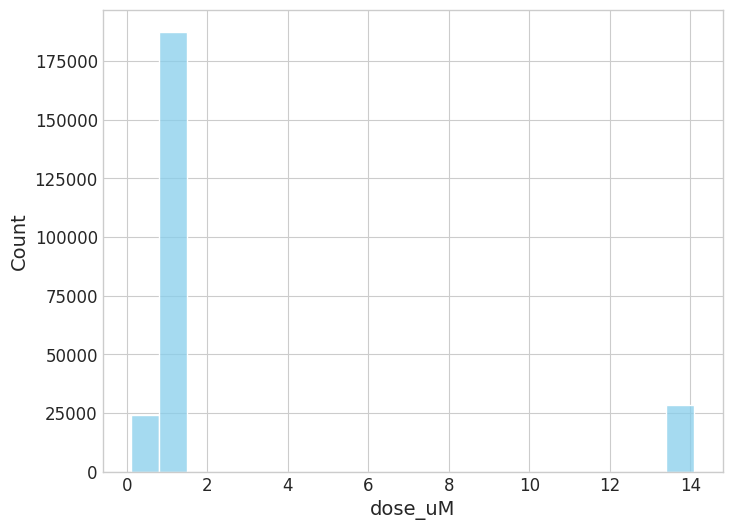

In [74]:
sns.histplot(data=adata_obs, x='dose_uM', bins=20, color='skyblue')

In [75]:
adata_obs.columns

Index(['obs_id', 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id',
       'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM',
       'timepoint_hr', 'control'],
      dtype='object')

In [76]:
de_train.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [77]:
adata_obs.head()

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False


In [78]:
# extract only rows of adata_obs based on sm_lincs_id in de_train
sm_lincs_id = list(de_train['sm_lincs_id'].unique())
print(len(sm_lincs_id))

adata_obs_train = adata_obs[adata_obs['sm_lincs_id'].isin(sm_lincs_id)]
adata_obs_train.shape

146


(211628, 15)

,Number,Percent
sm_name,,
R428,6,0.009772
MLN 2238,6,0.009772
Dactolisib,6,0.009772
LDN 193189,6,0.009772
Porcn Inhibitor III,6,0.009772
...,...,...
Masitinib,4,0.006515
GSK-1070916,4,0.006515
Isoniazid,4,0.006515


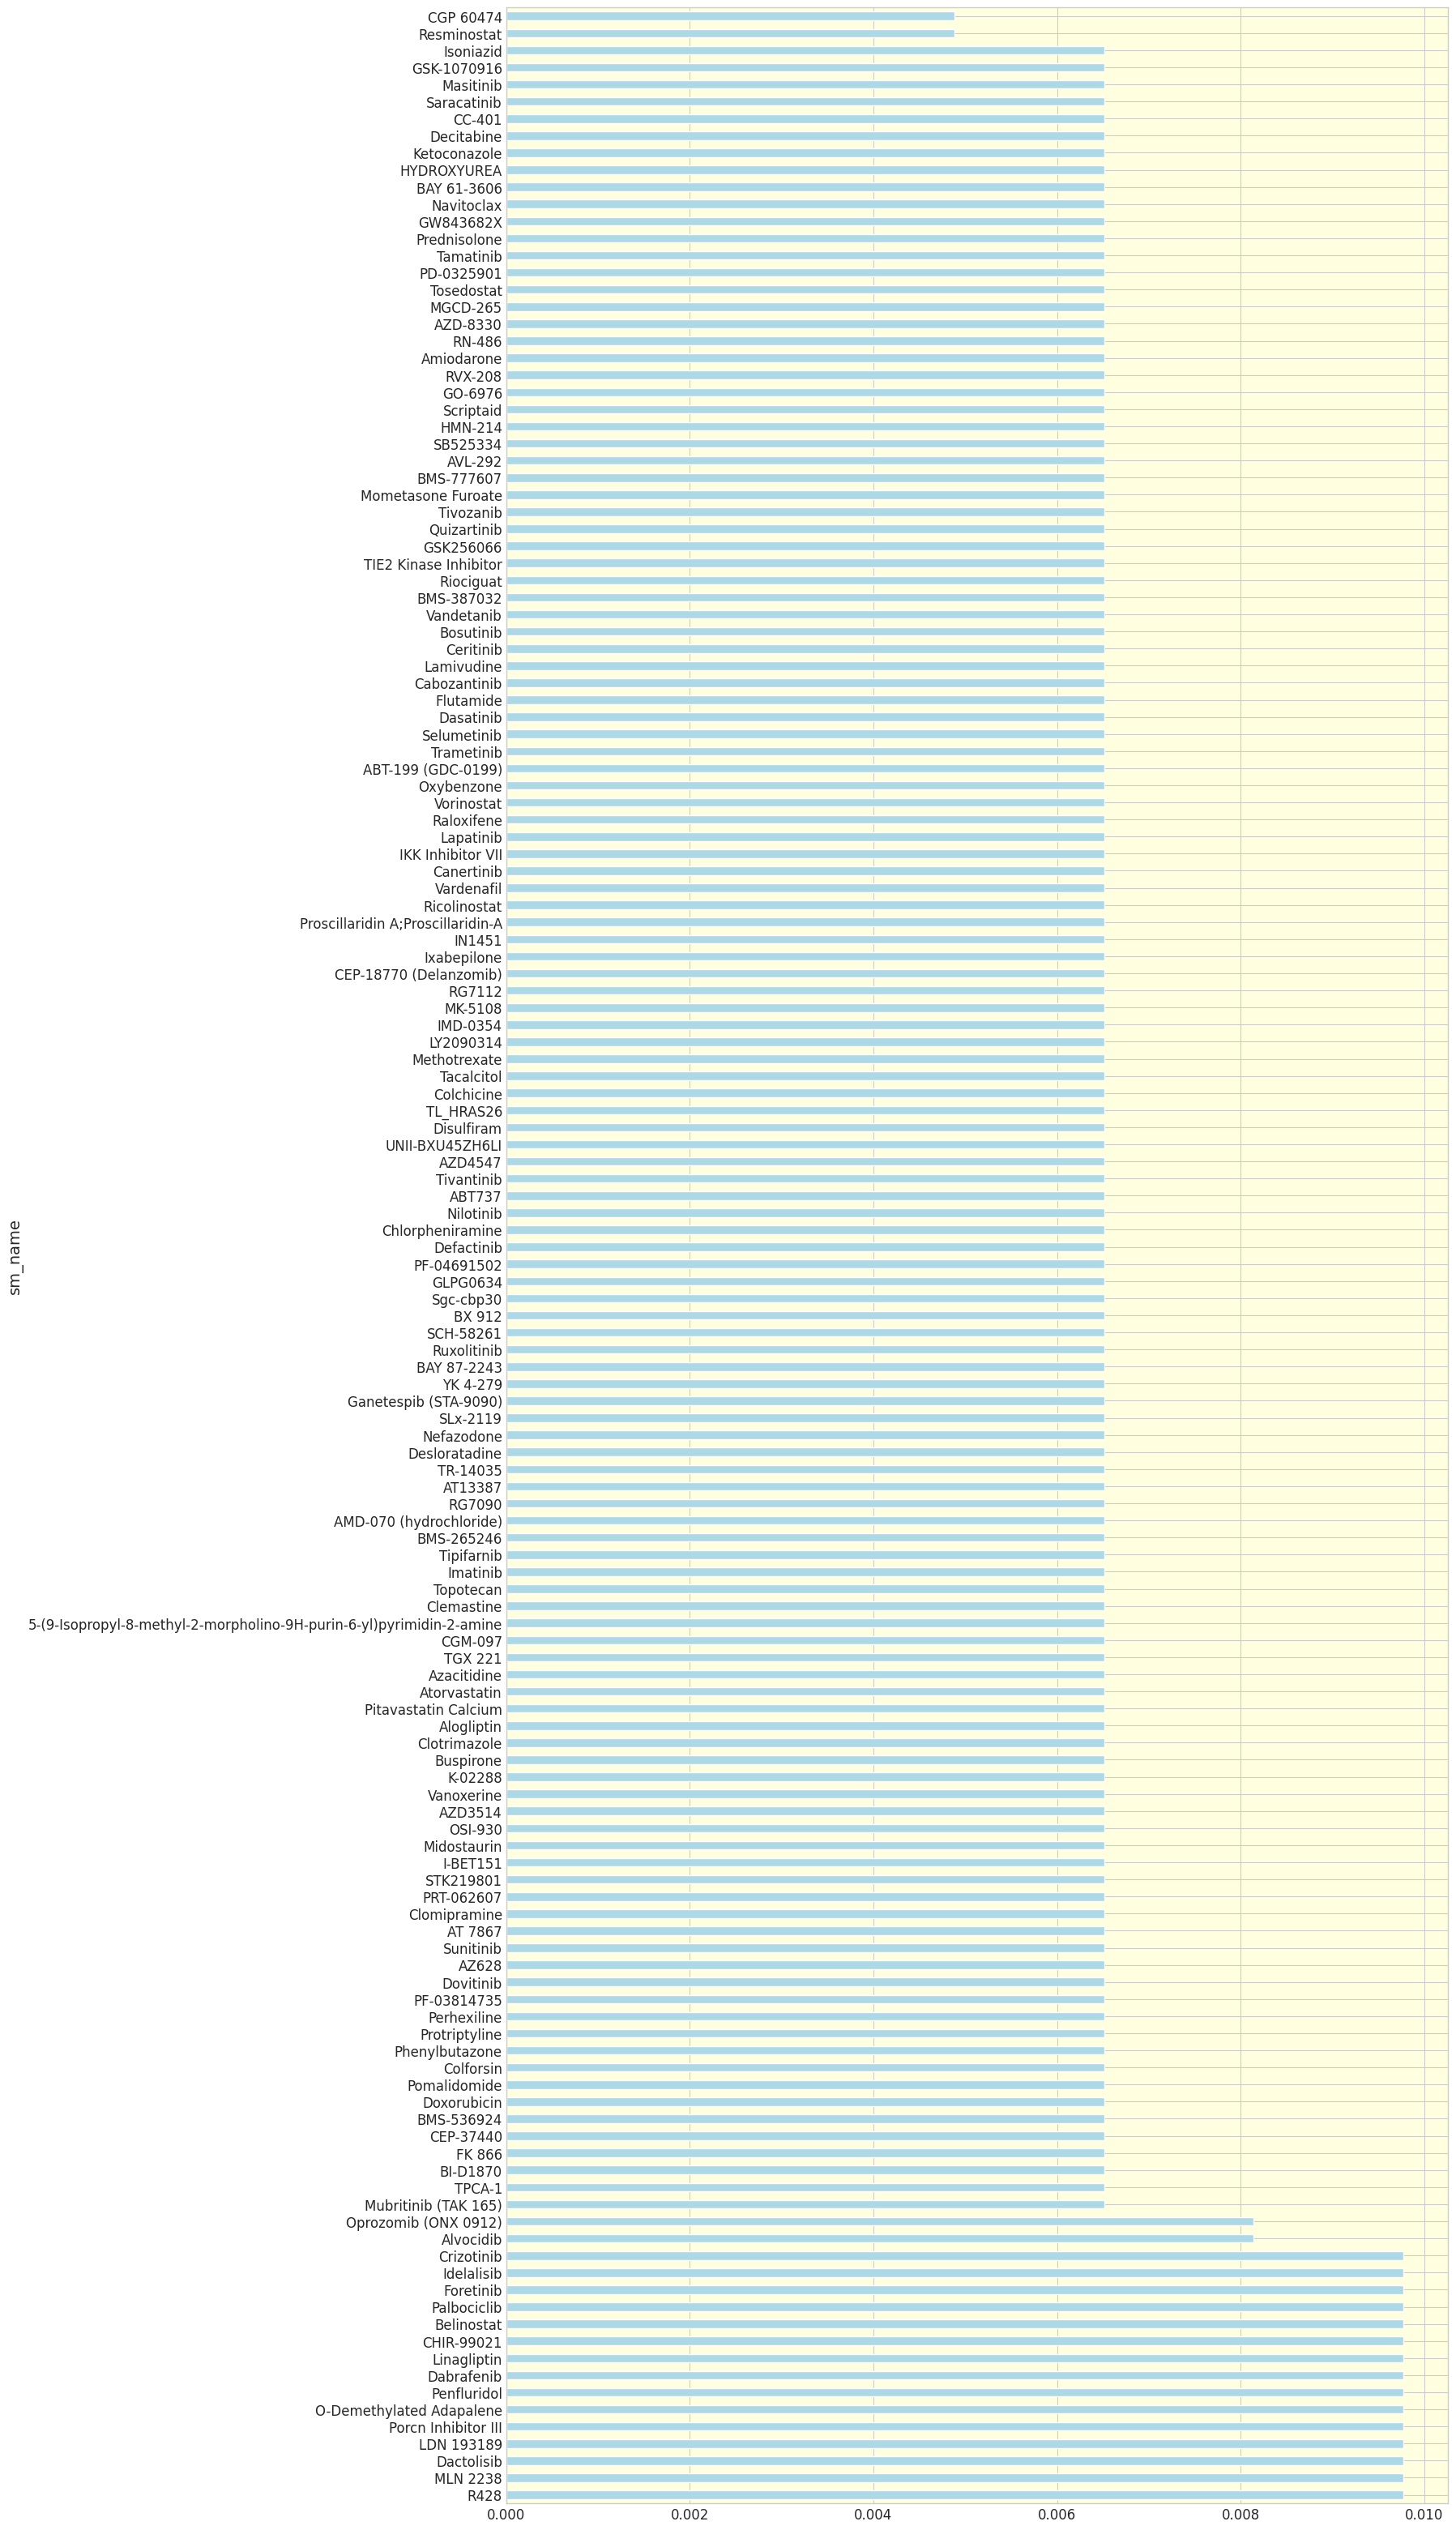

In [79]:
plt.gca().set_facecolor('lightyellow')
de_train['sm_name'].value_counts(normalize=True).plot(kind='barh', figsize=(15,40), color=['lightblue'])

pd.DataFrame(data= {'Number': de_train['sm_name'].value_counts(), 
                    'Percent': de_train['sm_name'].value_counts(normalize=True)})

In [80]:
import re
# Thanks to: https://github.com/DocMinus

def element_count(data, N):
    smiles = data['SMILES'].iloc[N]

    pattern = "Si|Ti|Al|Zn|Pd|Pt|Br?|Cl?|N|O|S|P|F|I|B|b|c|n|o|s|p" 
    regex = re.compile(pattern)
    elements = [token for token in regex.findall(smiles)]
    ele_length = len(elements)
    lowercase_pattern = "b|c|n|o|s|p"
    regex_low = re.compile(lowercase_pattern)
    for i in range(ele_length):
        if regex_low.findall(elements[i]):
            elements[i] = elements[i].upper()
    element_count = [elements.count(ele) for ele in elements]
    formula = dict(zip(elements, element_count)) 

    print('==> Element_Count: ', str(formula))

,469
cell_type,T cells CD8+
sm_name,Nefazodone
sm_lincs_id,LSM-4031
SMILES,CCc1nn(CCCN2CCN(c3cccc(Cl)c3)CC2)c(=O)n1CCOc1c...


==> Element_Count:  {'C': 25, 'N': 5, 'Cl': 1, 'O': 2}


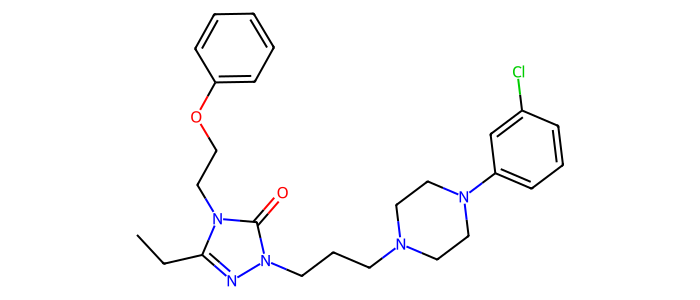

In [81]:
N = random.randrange(len(de_train))
cols_sel = ['cell_type','sm_name','sm_lincs_id','SMILES']

smiles = de_train['SMILES'][N]
mol = Chem.MolFromSmiles(smiles)
img = Draw.MolToImage(mol, size=(700, 300), fitImage=True)    
display(pd.DataFrame(de_train[cols_sel].iloc[N]))

element_count(de_train, N)
img

In [82]:
de_train_exp = de_train.drop(columns = ["cell_type", "sm_name", "sm_lincs_id", "SMILES", "control"])

de_train_exp.head()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


## Exploratory Data Analysis (EDA)

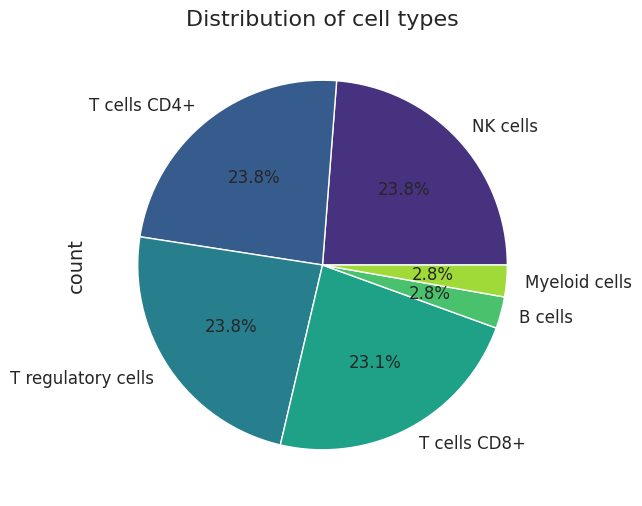

In [83]:
# visualise relative amount of cell types in dataset

de_train['cell_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=12)
plt.title('Distribution of cell types')
plt.show()


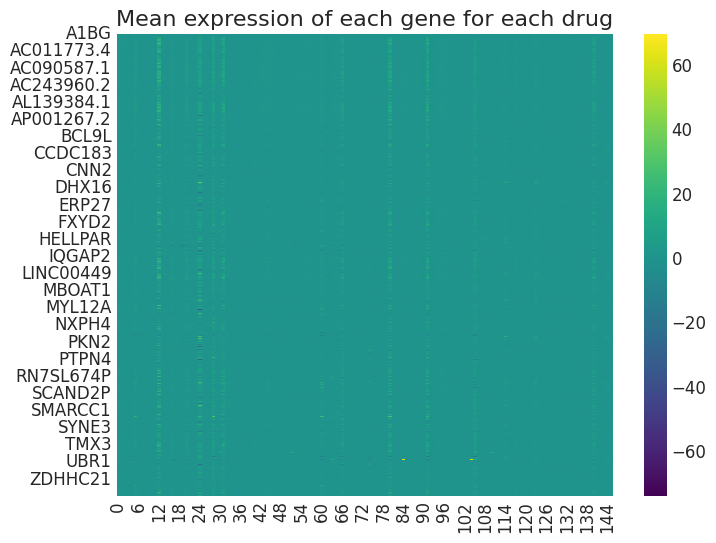

In [84]:
# Create a new DataFrame 'df_simple' by selecting columns 1 (sm_name) and 5 to the last column
df_simple = de_train.iloc[:, [1] + list(range(5, de_train.shape[1]))]

# Calculate the mean of each group based on 'sm_name' and reset the index
mean_df = df_simple.groupby('sm_name').mean().reset_index()

# Display the DataFrame containing the mean values
mean_df

# plot the mean expression of each gene for each drug
sns.heatmap(mean_df.iloc[:, 1:].transpose(), cmap='viridis')
plt.title('Mean expression of each gene for each drug')
plt.show()

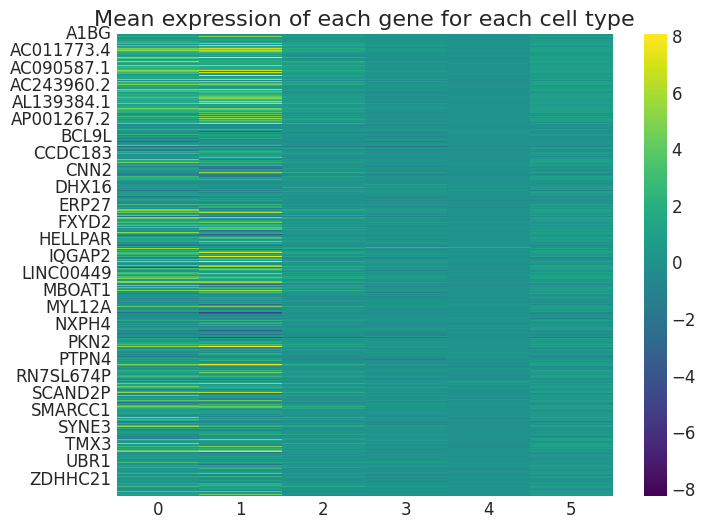

In [85]:
# Create a new DataFrame 'df_simple_org' by selecting columns 0 (cell_type) and 5 to the last column
df_simple_org = de_train.iloc[:, [0] + list(range(5, de_train.shape[1]))]

# 📈 Calculate the mean of each group based on 'cell_type' and reset the index
mean_df_org = df_simple_org.groupby('cell_type').mean().reset_index()

# 📄 Display the DataFrame containing the mean values by cell type
mean_df_org

# plot the mean expression of each gene for each cell type
sns.heatmap(mean_df_org.iloc[:, 1:].transpose(), cmap='viridis')
plt.title('Mean expression of each gene for each cell type')
plt.show()

In [90]:
# Distribution of "cell_type" values for each unique "sm_name" value
distribution_sm_name = data.groupby('sm_name')['cell_type'].value_counts().unstack().fillna(0)

# Sorting the distribution based on the total count of relations
sorted_distribution = distribution_sm_name.sum(axis=1).sort_values(ascending=False)
sorted_distribution_df = distribution_sm_name.loc[sorted_distribution.index]

# Limiting the size of the x-axis labels
labels = [label[:15] + '...' if len(label) > 15 else label for label in sorted_distribution_df.index]

# Plotting the graph
plt.figure(figsize=(20, 6.7))
sorted_distribution_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of $cell\_type$ by $sm\_name$', fontsize=30, fontweight='bold')
plt.xlabel('')
plt.ylabel('Count of Relations', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.tight_layout()

plt.show()

NameError: name 'data' is not defined

#### SMILES representation

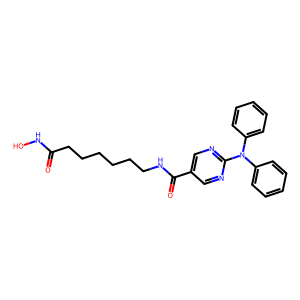

In [86]:
# draw molecules from SMILES
from rdkit import Chem
from rdkit.Chem import Draw

smiles = de_train['SMILES'][100]

# Create an RDKit molecule object from the SMILES string
molecule = Chem.MolFromSmiles(smiles)

Draw.MolToImage(molecule)

In [87]:
df_chem = de_train[["sm_name", "SMILES"]]
df_chem = df_chem.drop_duplicates().reset_index(drop=True).set_index("sm_name")
df_chem

,SMILES
sm_name,
Clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
Idelalisib,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
Bosutinib,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
...,...
CGM-097,COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(...
TGX 221,Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCOCC3)cc(=O)n2c1
Azacitidine,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1


In [88]:
from rdkit.Chem.AtomPairs import Sheridan

df_chem["fingerprint"] = None
df_chem["mol"] = None
df_chem["mol"] = df_chem["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))

for name in df_chem.index:
    fg = Sheridan.GetBPFingerprint(df_chem.at[name, "mol"])
    df_chem.at[name, "fingerprint"] = fg

In [89]:
df_chem["distance"] = 0
df_chem["distance"] = df_chem["fingerprint"].apply(
    lambda x: np.array(DataStructs.cDataStructs.BulkDiceSimilarity(x, df_chem["fingerprint"].values.tolist(), returnDistance=True))
)

NameError: name 'DataStructs' is not defined

In [ ]:
import umap
# do UMAP clustering
mapper = umap.UMAP(random_state=42,
                   n_neighbors=3,
                   min_dist=0.6,
                   metric="correlation")
embedding = mapper.fit_transform(df_chem["distance"].values.tolist())

embedding_x = embedding[:, 0]
embedding_y = embedding[:, 1]

plt.scatter(embedding_x, embedding_y, s=30)

plt.grid()
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Visualization of Coumpunds")
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(embedding)
df_chem["label"] = kmeans.labels_
colors=["r", "b", "g", "y", "m", "c", "k"]

for i in range(5):
    lab_idx = np.where(kmeans.labels_==i)
    if i >= len(colors):
        marker = "^"
    else:
        marker = "o"
    c_i = i%len(colors)
    plt.scatter(embedding_x[lab_idx], embedding_y[lab_idx], marker=marker, label=i, s=30, color=colors[c_i])

plt.title("visualization of coumpaunds after clustering")

In [ ]:
from IPython.display import display
for label in range(5):
    df_chem_lab = df_chem[df_chem["label"]==label]
    mols = df_chem_lab["mol"].values.tolist()
    legends = df_chem_lab.index.values.tolist()
    
    img = Draw.MolsToGridImage(mols[:5],
                               molsPerRow=5, 
                               subImgSize=(200,200),
                               legends=legends[:5]
                               )
    print(f"label : {label}")
    display(img)

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.cluster import AgglomerativeClustering

smiles_list = ["SMILES1", "SMILES2", "SMILES3", ...]

fingerprints = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, 2048) for smiles in smiles_list]

def tanimoto_similarity(fp1, fp2):
    intersection = sum([a & b for a, b in zip(fp1, fp2)])
    union = sum([a | b for a, b in zip(fp1, fp2)])
    return intersection / union

# Calculate pairwise similarities
similarity_matrix = [[tanimoto_similarity(fp1, fp2) for fp2 in fingerprints] for fp1 in fingerprints]

n_clusters = 5  # Define the number of clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
labels = clustering.fit_predict(1 - similarity_matrix)  # Using 1 - similarity to convert similarity to distance

for cluster_id in range(n_clusters):
    cluster_smiles = [smiles_list[i] for i, label in enumerate(labels) if label == cluster_id]
    print(f'Cluster {cluster_id}: {cluster_smiles}')


In [ ]:
# # Function to convert SMILES to RDKit molecule
# def smiles_to_mol(smiles):
#     return Chem.MolFromSmiles(smiles)

# # Function to draw molecule from RDKit molecule object
# def draw_molecule(mol, title, save_path):
#     img = Draw.MolToImage(mol)
#     img = img.resize((400, 400))  # Resize to a reasonable size
#     img.save(save_path)  # Save the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(img)
#     plt.title(title)
#     plt.axis('off')
#     plt.show()


# # Randomly select 10 different images
# sampled_df = de_train.sample(n=10, random_state=42)

# # Example usage of the functions
# for i, row in sampled_df.iterrows():
#     mol = smiles_to_mol(row['SMILES'])
#     if mol:
#         image_path = f'{row["sm_name"]}.png'  # Define the image path
#         draw_molecule(mol, row['sm_name'], image_path)

NameError: name 'Chem' is not defined

In [ ]:
# cross-validation

#### Control vs. Treatment

In [ ]:
# calculate quality metrics on de_train

# set all columns from the 6th column as numeric
de_train_exp.iloc[:, 6:] = de_train_exp.iloc[:, 6:].apply(pd.to_numeric)

# calculate mean and variance per cell type
de_train['mean'] = de_train_exp.mean(axis = 1)
de_train['variance'] = de_train_exp.var(axis = 1)

# calculate dispersion
de_train['dispersion'] = de_train['variance'] / de_train['mean']

# calculate mean and variance per gene
de_train['mean_gene'] = de_train_exp.mean(axis = 1)
de_train['variance_gene'] = de_train_exp.var(axis = 1)

# calculate dispersion
de_train['dispersion_gene'] = de_train['variance_gene'] / de_train['mean_gene']

# 602 cells in treatment and 12 in control

# extract cell types with control == True and False
de_train_control = de_train[de_train['control'] == True]
de_train_treatment = de_train[de_train['control'] == False]

# calculate means of means in de_train_control and de_train_treatment by cell type
de_train_control_mean =[]
de_train_treatment_mean =[]

for cell_type in de_train['cell_type'].unique():
    de_train_control_mean.append(de_train_control[de_train_control['cell_type'] == cell_type]['mean'].mean())
    de_train_treatment_mean.append(de_train_treatment[de_train_treatment['cell_type'] == cell_type]['mean'].mean())
    print(cell_type)
    print("control: " + str(de_train_control[de_train_control['cell_type'] == cell_type]['mean'].mean()))
    print("treatment: " + str(de_train_treatment[de_train_treatment['cell_type'] == cell_type]['mean'].mean()))
    print("")

NK cells
control: 1.0310179183587806
treatment: 0.40366254638612703

T cells CD4+
control: -0.38448275514356484
treatment: 0.16127054160290108

T cells CD8+
control: -0.18831669781726246
treatment: 0.035586867650863066

T regulatory cells
control: 8.3730331964234
treatment: 0.378899370667098

B cells
control: 0.1330984680918511
treatment: 1.3113020173248955

Myeloid cells
control: 0.5667428028795622
treatment: 1.2589277984067706



In [ ]:
# calculate log2 fold change of treatment vs control
de_train_log2fc_mean = np.log2(de_train_treatment_mean / de_train_control_mean)

# visualize log2 fold change of treatment vs control
sns.barplot(x = de_train_log2fc_mean.index, y = de_train_log2fc_mean.values)
plt.xticks(rotation = 90)
plt.xlabel("cell type")
plt.ylabel("log2 fold change")
plt.title("log2 fold change of treatment vs control by cell type")
plt.show()

TypeError: unsupported operand type(s) for /: 'list' and 'list'

/home/katerchen/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/katerchen/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 800x600 with 0 Axes>

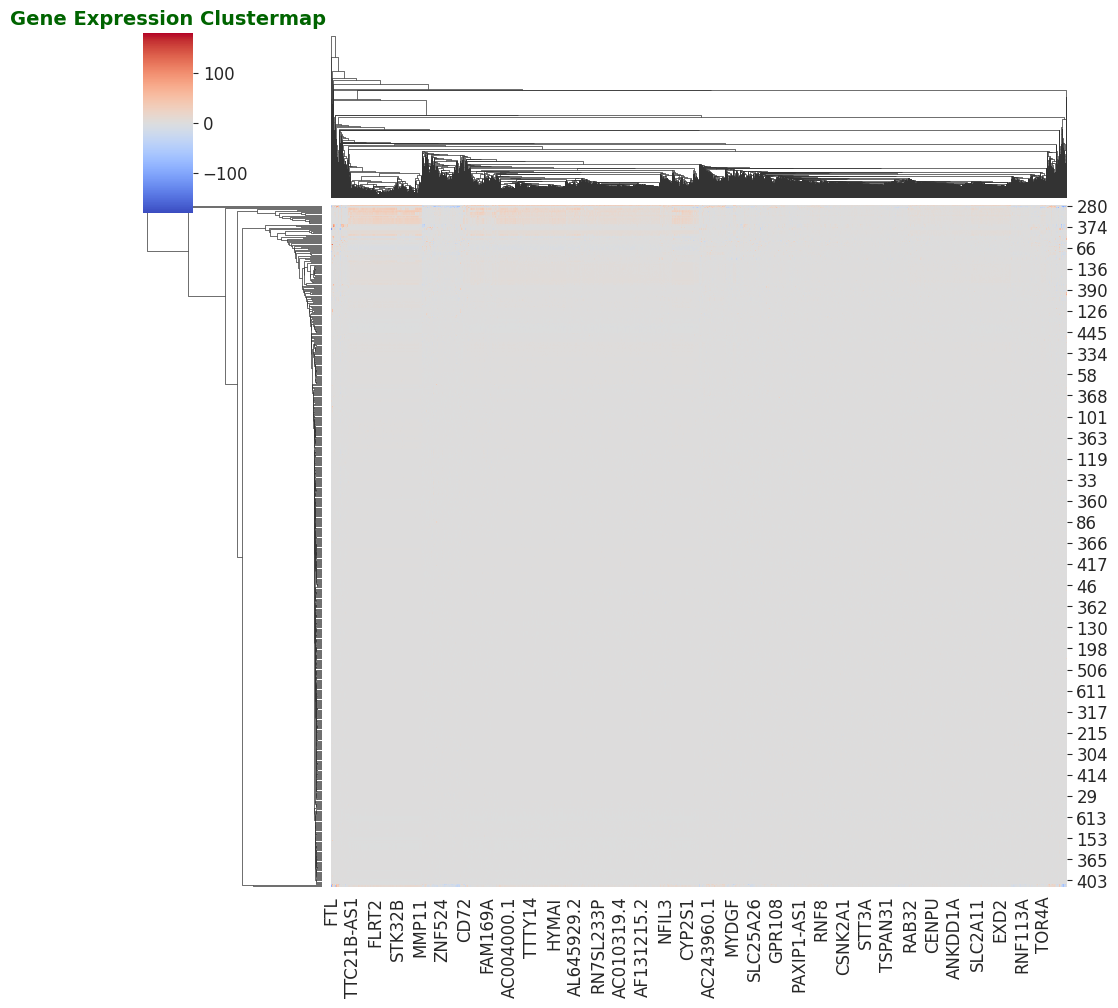

In [ ]:
plt.figure(figsize=(8, 6))
sns.clustermap(de_train.drop(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=1), cmap='coolwarm')
plt.title('Gene Expression Clustermap', fontsize = 14, fontweight = 'bold', color = 'darkgreen')
plt.savefig('Gene Expression Clustermap.png')
plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
target_2d = pca.fit_transform(de_train.iloc[:,5:])
target_2d.shape

(614, 2)

In [ ]:
def plot_task(target, feature, headline):   
    colors  = ['darkblue','red','darkcyan','darkviolet','violet','yellow']
    classes = list(feature.unique())
    
    plt.style.use('seaborn-whitegrid') 
    plt.figure(figsize=(10, 4), facecolor='lightyellow')
    for u, c in zip(classes, colors):
        plt.scatter(target[:,0][feature==u], target[:,1][feature==u], c=c, s=10)
        
    plt.gca().set_facecolor('lightgray')
    plt.title(headline, fontsize=12)
    plt.legend(classes, loc=1)
    plt.show()

/tmp/ipykernel_4055/3422571804.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


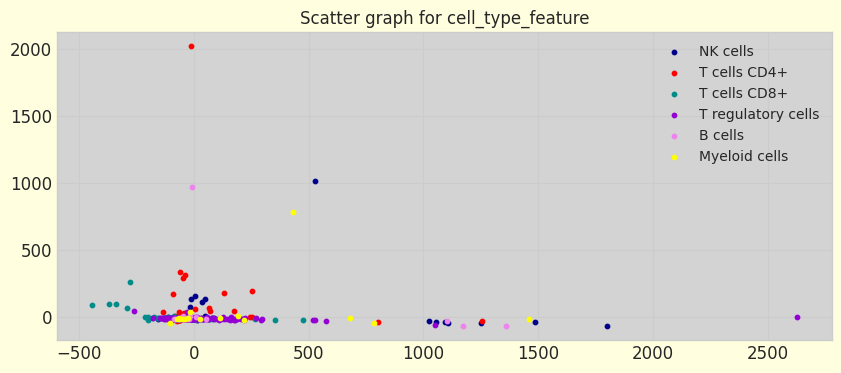

In [ ]:
plot_task(target_2d, de_train['cell_type'], 'Scatter graph for cell_type_feature')

/tmp/ipykernel_4055/3422571804.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


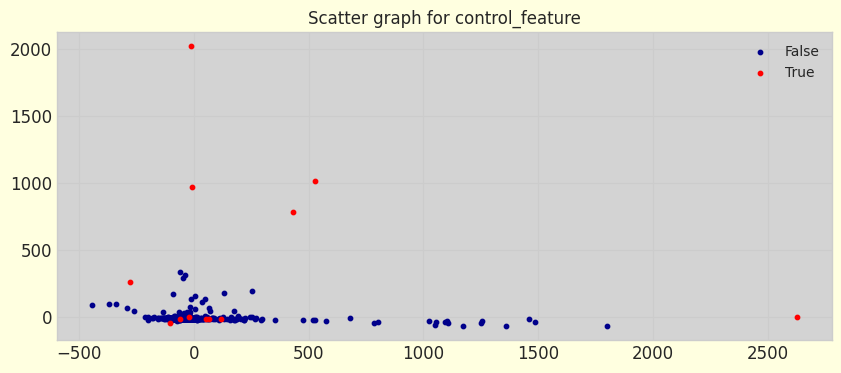

In [ ]:
plot_task(target_2d, de_train['control'], 'Scatter graph for control_feature')

In [93]:
from rdkit.Chem import AllChem

# Feature Extraction (Morgan Fingerprints)
de_train['Morgan_Fingerprints'] = de_train['SMILES'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=1024))

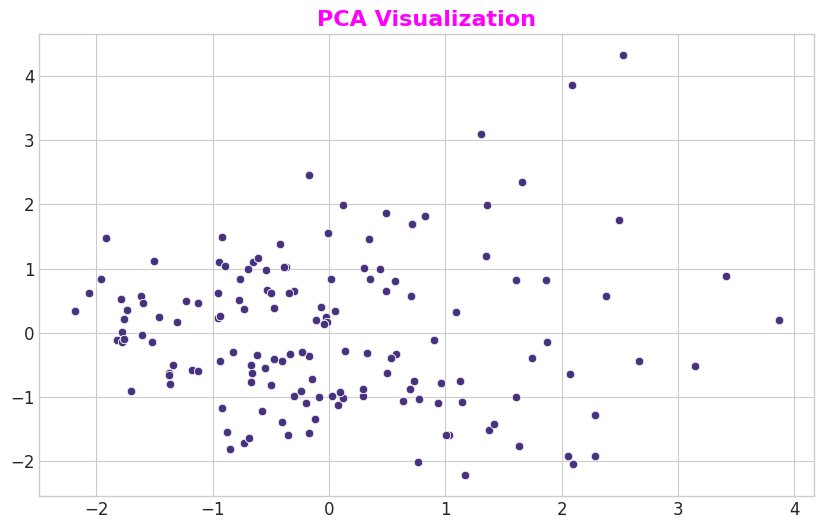

In [95]:
# PCA Visualization
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(list(de_train['Morgan_Fingerprints']))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1])
plt.title("PCA Visualization", fontweight = 'bold', color = 'magenta')
plt.savefig('PCA Visualization.png')
plt.show()

In [ ]:
import stats

cols_total = list(de_train.columns)
len(cols_total)

de_train_drop = de_train.drop(columns=['cell_type','sm_name','sm_lincs_id','SMILES','control'])
cols = list(de_train_drop.columns)
len(cols)

cols_select = []
alpha = 0.06

for col in cols:
    _, p_value = stats.shapiro(de_train_drop[col])
    
    if (p_value <= alpha): 
        cols_select.append(col)     
         
len(cols_select)

AttributeError: module 'stats' has no attribute 'shapiro'

In [ ]:
de_train_b = de_train[de_train['cell_type']=='B cells']

namelist_b = list(de_train_b['sm_name'])
namelist_b , len(namelist_b)
id_map_b = id_map[id_map['cell_type']=='B cells']

namelist_b_sub = list(id_map_b['sm_name'])
len(namelist_b_sub)
common_member_b = [f for f in namelist_b_sub if f in namelist_b]
common_member_b

NameError: name 'id_map' is not defined

In [ ]:
def mrrmse(y_pred: pd.DataFrame, y_true: pd.DataFrame):
    
    return ((y_pred - y_true)**2).mean(axis=1).apply(np.sqrt).mean()

#### UMAP

In [ ]:
# calculate umap for adata with scanpy
de_train_exp = sc.AnnData(de_train_exp)

sc.pp.normalize_total(de_train_exp)
# sc.pp.log1p(de_train_exp)
sc.pp.pca(de_train_exp)
sc.pp.neighbors(de_train_exp)
sc.tl.umap(de_train_exp)

# store cell annotation in adata.obs
de_train_exp.obs["cell_type"] = de_train["cell_type"].values


/home/katerchen/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/katerchen/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


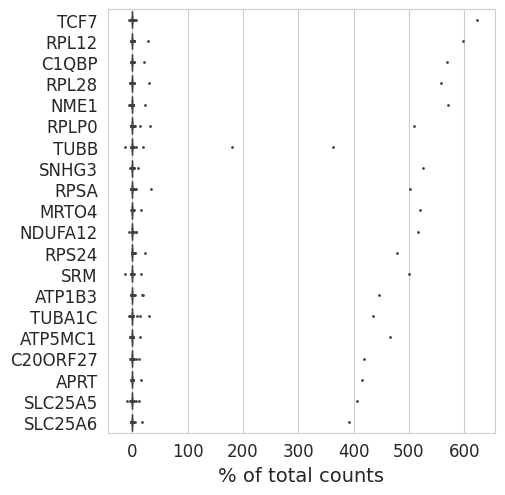

In [ ]:
sc.pl.highest_expr_genes(de_train_exp, n_top=20, )

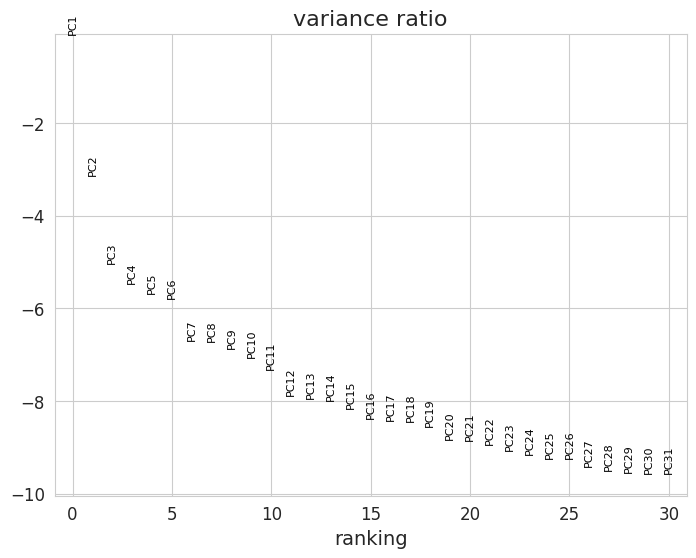

In [ ]:
sc.tl.pca(de_train_exp, svd_solver='arpack')
sc.pl.pca_variance_ratio(de_train_exp, log=True)

/home/katerchen/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/katerchen/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/katerchen/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


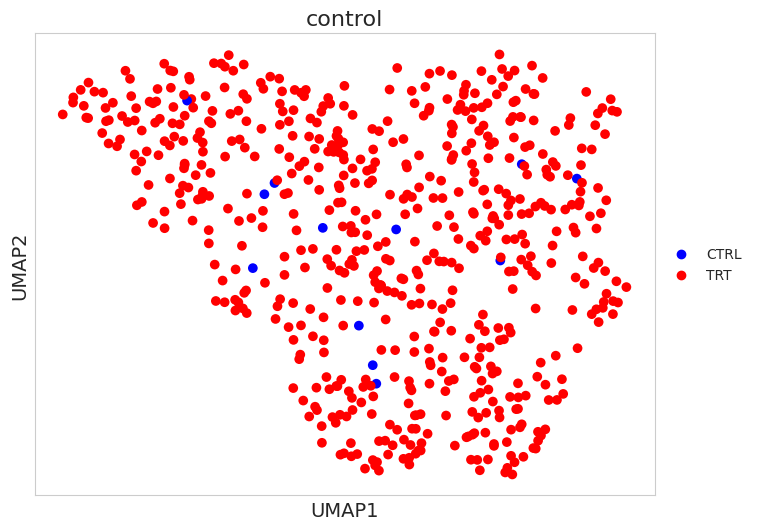

In [ ]:
de_train_exp.obs['control'] = de_train['control'].values

# replace True with 'CTRL' and False with 'TRT'
de_train_exp.obs['control'].replace(True, 'CTRL', inplace = True)
de_train_exp.obs['control'].replace(False, 'TRT', inplace = True)

# plot umap
sns.set_palette(['blue', 'red'])
sc.pl.umap(de_train_exp, color = ['control'])

In [ ]:
# remove control cells from de_train_exp
de_train_exp = de_train_exp[de_train_exp.obs['control'] == 'TRT']

# calculate umap for de_train_exp
sc.pp.normalize_total(de_train_exp)
# sc.pp.log1p(de_train_exp)
sc.pp.pca(de_train_exp)
sc.pp.neighbors(de_train_exp)
sc.tl.umap(de_train_exp)

/home/katerchen/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/katerchen/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/home/katerchen/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/katerchen/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/katerchen/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


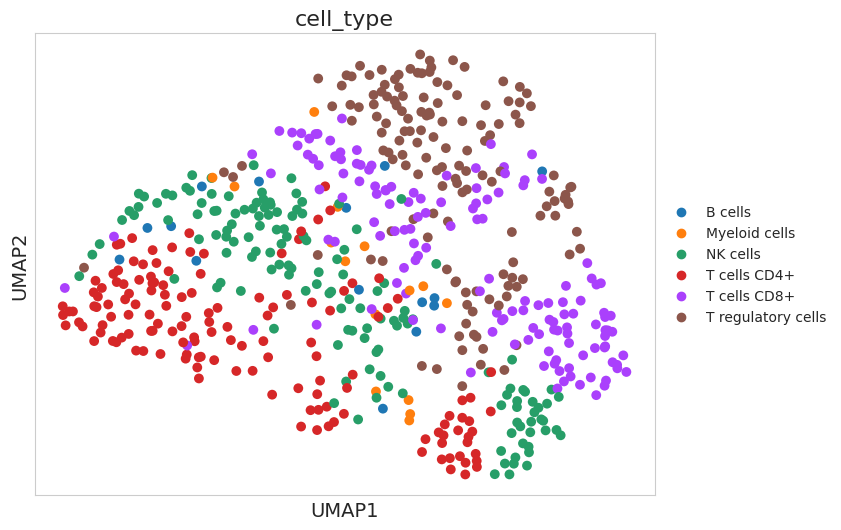

In [ ]:
sc.pl.umap(de_train_exp, color = 'cell_type', cmap='magma')

In [ ]:
X = de_train.iloc[:,5:]
print(X.shape)

(614, 18217)


SMILES Encoding => Molecular Fingerprinting

In [ ]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZXDC,ZYG11B,ZYX,ZZEF1,mean,variance,dispersion,mean_gene,variance_gene,dispersion_gene
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.094959,0.034127,0.221377,0.368755,0.114498,0.357204,3.119731,0.114498,0.357204,3.119731
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.095079,0.704780,1.096702,-0.869887,0.020473,0.319549,15.608448,0.020473,0.319549,15.608448
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.213550,0.415768,0.078439,-0.259365,-0.235096,0.267982,-1.139884,-0.235096,0.267982,-1.139884
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.224700,-0.048233,0.216139,-0.085024,0.323229,0.329641,1.019839,0.323229,0.329641,1.019839
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,-0.819775,0.112365,-0.122193,0.676629,0.640715,2.745794,4.285518,0.640715,2.745794,4.285518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.528817,0.105138,0.491015,-0.979951,-0.477640,0.351046,-0.734959,-0.477640,0.351046,-0.734959
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,0.034144,-0.231642,1.023994,-0.064760,0.063603,0.316382,4.974303,0.063603,0.316382,4.974303
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.552810,-0.209077,0.389751,-0.337082,-0.021596,0.275619,-12.762443,-0.021596,0.275619,-12.762443
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.012862,-0.029684,0.005506,-1.733112,-0.301588,0.359209,-1.191059,-0.301588,0.359209,-1.191059


https://www.kaggle.com/code/dangnguyen97/linearsvr

In [ ]:
# LinearSVR & MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=421)
model = LinearSVR(max_iter= 1000, epsilon= 0.1)
wrapper = MultiOutputRegressor(model)
wrapper.fit(X_train, y_train)
predict = wrapper.predict(X_test) 
#mrrmse(pd.DataFrame(predict), pd.DataFrame(y_test.values))
N = random.randrange(predict.shape[1])

plt.style.use('seaborn-whitegrid') 
plt.figure(figsize=(8, 4), facecolor='lightyellow')
plt.title(f'Column:  #{N}', fontsize=12)
plt.gca().set_facecolor('lightgray')

sns.distplot(y_test.values[:,N]-predict[:,N], bins=100, color='red')
plt.legend(['y_true','y_pred'], loc=1)
plt.show()
Final model
model = LinearSVR(max_iter= 1500, epsilon= 0.075)

wrapper = MultiOutputRegressor(model)
wrapper.fit(X, y)
submission1 = pd.DataFrame(wrapper.predict(test), columns= de_train.columns[5:])
submission1.index.name = 'id'
#submission1
submission1.to_csv('submission1.csv')
!ls
Ensembling
submission2 = pd.read_csv('../input/op2-603/op2_603.csv', index_col='id')
#submission2
col = list(de_train.columns[5:])
submission = submission1.copy()

submission[col] = (submission2[col] *0.70) + (submission1[col] *0.30)
#submission
submission.to_csv('submission.csv')

1. Chemical Reaction Computations
2. Chemical Property Calculation
3. Chemical Similarity and Clustering
4. Enrichment Analysis => SMARTS pattern for aromatic rings, MACCS fingerprints for each molecule
5. Statistical Testing

In [ ]:
# Split Data into training, validation and test sets

from sklearn.preprocessing import OneHotEncoder

features_columns = ["cell_type", "sm_name"]
features = pd.DataFrame(de_train, columns=features_columns)

# Create an instance of the encoder
encoder = OneHotEncoder()

# Fit the encoder on features
encoder.fit(features)

# Transform the features into one-hot encoded format
one_hot_encode_features = encoder.transform(features)

# Transform the test data(id_map)
one_hot_test = encoder.transform(test_data)
# check shape
one_hot_encode_features.toarray().shape, one_hot_test.toarray().shape

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(one_hot_encode_features, labels.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [ ]:
# Printing the shapes of the data splits
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# We also get full features for final training 
full_features = one_hot_encode_features.toarray()
full_labels = labels.values

In [ ]:
print("full_features shape:", full_features.shape)
print("full_labels shape:", full_labels.shape)

=> model: NN (https://www.kaggle.com/code/adaluodao/1-op2-eda-linearsvr-regressorchain-4d5440#Predicting-on-test-data)

## Decoupler & Omnipath

In [ ]:
import decoupler as dc
import pandas as pd

In [ ]:
try:
    # Query the DB to obtain the most updated version of the TF - Gene interactions for the enrichment analysis.
    df_collectri = dc.get_collectri(organism='human', split_complexes=False)
except:
    df_collectri = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
df_collectri

In [ ]:
tf_activities, p_values = dc.run_ulm(
    mat=df,
    net=df_collectri,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
)
tf_activities

In [ ]:
dc.plot_barplot(tf_activities, 'NK cells@Dabrafenib', top = 25, vertical = True)

NOTE: Remeber that in the dataset, what we have is -log(p_values) of the differential expression analysis. This does not give us information about the effect size. For better interpretation, these plots should be used with log fold changes

In [ ]:
dc.plot_targets(
    df.loc[["NK cells@Dabrafenib"],:].T, 
    stat = 'NK cells@Dabrafenib',
    source_name = 'MYC', 
    net = df_collectri, 
    top = 15
)

Since Decoupler returns two dataframes, one with effect sizes and the other with p-values, we can use for example the p-values to generate features that will look very similar to the original ones used in the competition:

In [ ]:
import numpy as np

df_tfpval = -np.log(p_values+1e-10) * np.sign(tf_activities)
df_tfpval

If the idea is to use only a bunch of TFs as features for prediction, a good strategy can be to pick only the top variable genes across conditions:

In [ ]:
# Using the TF activities
tf_activities.std(axis=0).sort_values(ascending=False).head(10)

In [ ]:
# Using the -log(p vals)
df_tfpval.std(axis=0).sort_values(ascending=False).head(10)

# Model testing

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'sm_name' and 'sm_lincs_id' are categorical variables
df2 = pd.get_dummies(df2, columns=['sm_name', 'sm_lincs_id','cell_type'])


# Separate features and target variable
X = df2.drop(['control'], axis=1)
y = df2['control']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Build Models

# Linear Regression
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression()

# Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic_reg_model = LogisticRegression()

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier()

# Support Vector Machine (SVM)
from sklearn.svm import SVC
svm_model = SVC()

# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

# K-Means Clustering
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=2)  # Assuming 2 clusters

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
naive_bayes_model = GaussianNB()

# Neural Network (Multi-layer Perceptron)
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(max_iter=1000)  # Assuming 1000 iterations
# Train the Models

linear_reg_model.fit(X_train, y_train)
logistic_reg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
kmeans_model.fit(X_train)
naive_bayes_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)


# Make Predictions

linear_reg_predictions = linear_reg_model.predict(X_test)
logistic_reg_predictions = logistic_reg_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)
kmeans_predictions = kmeans_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)
nn_predictions = nn_model.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score

# Define a function to print results
def print_results(model_name, y_true, y_pred):
    print(f"Results for {model_name}:")
    
    if isinstance(y_pred[0], int):  # Classification
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
    else:  # Regression
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"Mean Absolute Error: {mae}")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared (R2): {r2}")

# Define model names and predictions
model_names = ["Linear Regression", "Logistic Regression", "Decision Tree", 
               "Random Forest", "SVM", "KNN", "K-Means", 
               "Naive Bayes", "Neural Network"]
predictions = [linear_reg_predictions, logistic_reg_predictions.astype(int), 
               decision_tree_predictions.astype(int), random_forest_predictions.astype(int), 
               svm_predictions.astype(int), knn_predictions.astype(int), 
               kmeans_predictions.astype(int), naive_bayes_predictions.astype(int), 
               nn_predictions.astype(int)]

# Iterate through models and print results
for model_name, y_pred in zip(model_names, predictions):
    print_results(model_name, y_test, y_pred)
    print("\n" + "="*30 + "\n")  # Add a separator for better visibility

In [ ]:
# Import necessary libraries
import plotly.graph_objects as go

# Define model names and evaluation metrics
model_names = ["Linear Regression", "Logistic Regression", "Decision Tree", 
               "Random Forest", "SVM", "KNN", "K-Means", 
               "Naive Bayes", "Neural Network"]
accuracy_scores = [0.875, 0.9, 0.7, 0.8, 0.8, 0.9, 0.333, 0.9, 0.9]
precision_scores = [None, 0.909, 0.667, 0.75, 0.75, 0.909, 0.0, 0.909, 0.909]
recall_scores = [None, 0.833, 0.667, 0.833, 0.833, 0.833, 0.0, 0.833, 0.833]
f1_scores = [None, 0.869, 0.667, 0.789, 0.789, 0.869, 0.0, 0.869, 0.869]

# Create a bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=model_names, y=accuracy_scores, name='Accuracy', marker_color='blue'))
fig.add_trace(go.Bar(x=model_names, y=precision_scores, name='Precision', marker_color='green'))
fig.add_trace(go.Bar(x=model_names, y=recall_scores, name='Recall', marker_color='orange'))
fig.add_trace(go.Bar(x=model_names, y=f1_scores, name='F1 Score', marker_color='red'))

# Update the layout
fig.update_layout(barmode='group', title='Model Evaluation Metrics', xaxis_title='Model Name', yaxis_title='Score')
fig.show()